# 6) Function errors


## Today
* Conditioning and well posedness
* Relative and absolute errors
* Condition numbers

In [87]:
using Plots
default(linewidth=4, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Conditioning

We say that a mathematical function $f(x)$ is well conditioned if small changes in $x$ produce small changes in $f(x)$.
(What we mean by "small" will be made more precise.)

The function $f(x)$ may represent a simple expression such as

* $f(x) := 2 x$
* $f(x) := \sqrt{x}$
* $f(x) := \log{x}$
* $f(x) := x - 1$


A function may also represent something more complicated, implementable on a computer or by physical experiment.

* Find the positive root of the polynomial $t^2 + (1-x)t - x.$
* Find the eigenvectors of the matrix
$$ A(x) = \begin{bmatrix} 1 & 1 \\ 0 & x \end{bmatrix} .$$
* Find how much the bridge flexes when the truck of mass $x$ drives over it.
* Find the length of the rubber band when it finally snaps, as a function of temperature $x$ during manufacturing.
* Find the time at which the slope avalanches as a function of the wind speed $x$ during the storm.
* Find the probability that the slope avalanches in the next 48 hours as a function of the wind speed $x$ during the storm.
* Find the probability that the hurricane makes landfall as a function of the observations $x$.


# Specification

* Some of these problems are fully-specified
* Others involve sophisticated models and ongoing community research problems.
* In some cases, the models that are computable may incur greater uncertainty than the underlying system. In such cases, an analog experiment might produce smoother variation of the output as the problem data $x$ are varied.
* In others, the model might be better behaved than what it seeks to model.
* Some of these problems may be **ill-posed**

## Well-posedness

A problem is said to be [well-posed](https://en.wikipedia.org/wiki/Well-posed_problem) if
1. a solution exists,
2. the solution is unique, and
3. the solution depends continuously on the problem specification.

Mathematically, continuous variation in part 3 can be arbitrarily fast, but there may be measurement error, manufacturing tolerances, or incomplete specification in real-world problems, such that we need to quantify part 3.  This is the role of **conditioning**.


# Computing $e^x$

$$ e^x = \sum_{k=0}^{\infty} x^k/k! $$

In [88]:
function myexp(x)
    sum = 1
    for k in 1:100
        sum += x^k / factorial(big(k))
    end
    return sum
end
myexp(1) - exp(1)

1.445646891729250136554224997792468345749669676277240766303534163549513721620773e-16

In [89]:
function myexp(x)
    sum = 0
    term = 1
    n = 1
    while sum + term != sum
        sum += term
        term *= x / n
        n += 1
    end
    sum
end
myexp(1) - exp(1)

4.440892098500626e-16

# How accurate is it?

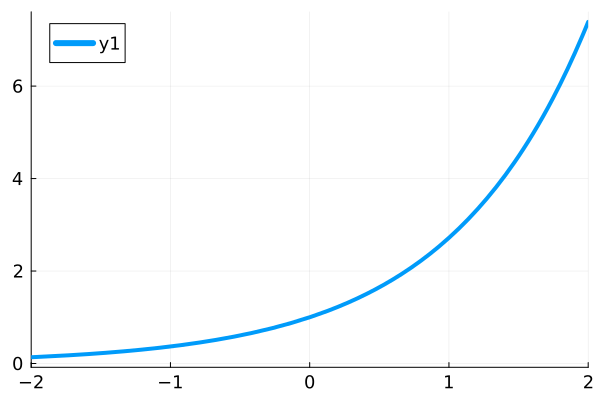

In [90]:
plot(myexp, xlims=(-2, 2))

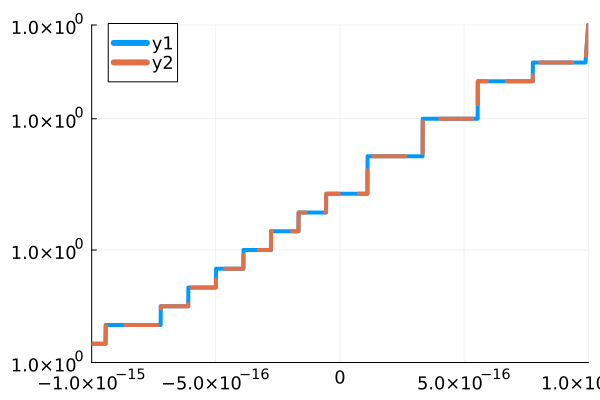

In [91]:
plot(exp, xlims=(-1e-15, 1e-15), linestyle=:solid)
plot!(myexp, xlims=(-1e-15, 1e-15), linestyle=:dash) # the bang operator overlays the second plot in the same figure

# What's happening?

* We're computing $f(x) = e^x$ for values of $x$ near zero.
* This function is well approximated by $1 + x$.
* Values of $y$ near 1 cannot represent every value.
* After rounding, the error in our computed output $\tilde f(x)$ is of order $\epsilon_{\text{machine}}$.

## Absolute Error
$$ \lvert \tilde f(x) - f(x) \rvert $$

## Relative Error
$$ \frac{\lvert \tilde f(x) - f(x) \rvert}{\lvert f(x) \rvert} $$

# Suppose I want to compute $e^x - 1$

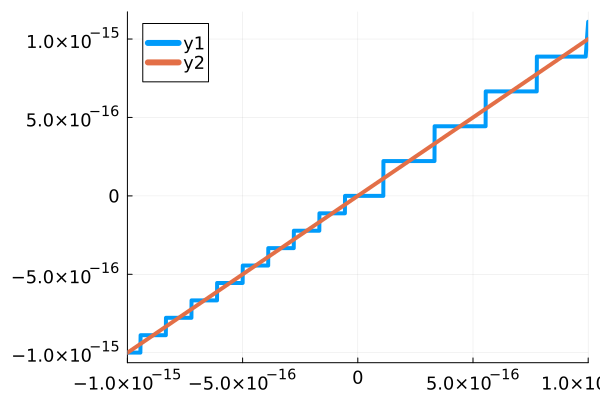

In [92]:
plot([x -> myexp(x) - 1 , x -> x],
     xlims=(-1e-15, 1e-15))

## What now?

* We're capable of representing outputs with 16 digits of accuracy
* Yet our algorithm `myexp(x) - 1` can't find them
* We can't recover without modifying our code

# Modify the code

In [93]:
function myexpm1(x)
    sum = 0
    term = x
    n = 2
    while sum + term != sum
        sum += term
        term *= x / n
        n += 1
    end
    sum
end

myexpm1 (generic function with 1 method)

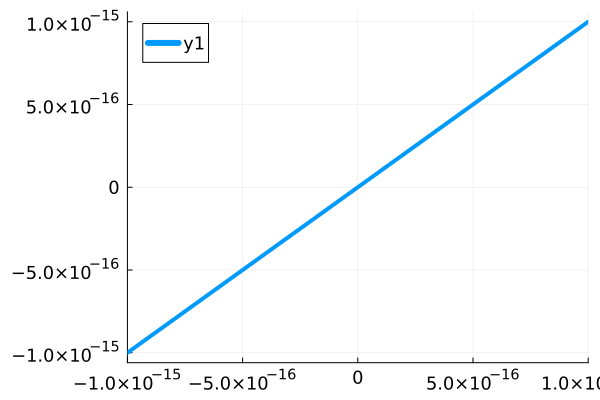

In [94]:
plot(myexpm1, xlims=(-1e-15, 1e-15))

# Plot relative error

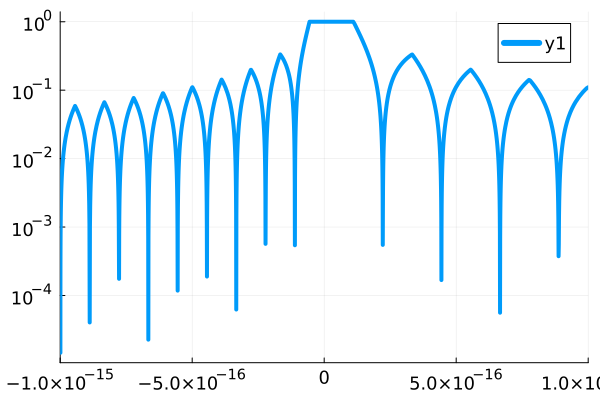

In [95]:
function relerror(x, f, f_ref)
    fx = f(x)
    fx_ref = f_ref(x)
    max(abs(fx - fx_ref) / abs(fx_ref), 1e-17)
end
badexpm1(t) = exp(t) - 1
plot(x -> relerror(x, badexpm1, expm1), yscale=:log10, xrange=(-1e-15, 1e-15))

# Floating point representation is **relative** (see [float.exposed](https://float.exposed))

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a9/IEEE_754_Double_Floating_Point_Format.svg" width="80%" />

Let $\operatorname{fl}$ round to the nearest floating point number.

$$ \operatorname{fl}(x) = x (1 + \epsilon), \quad \text{where} |\epsilon| \le \epsilon_{\text{machine}} $$

This also means that the relative error in representing $x$ is small:

$$ \frac{|\operatorname{fl}(x) - x|}{|x|} \le \epsilon_{\text{machine}} $$

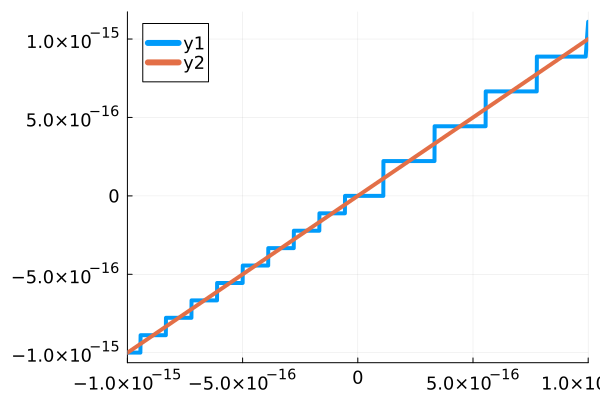

In [96]:
plot(x -> (1 + x) - 1, xlims=(-1e-15, 1e-15))
plot!(x -> x)

# Exact arithmetic, correctly rounded

Take an elementary math operation $*$ (addition, subtraction, multiplication, division), and the discrete operation that our computers perform, $\circledast$. Then

$$x \circledast y := \operatorname{fl}(x * y)$$

with a relative accuracy $\epsilon_{\text{machine}}$,

$$ \frac{|(x \circledast y) - (x * y)|}{|x * y|} \le \epsilon_{\text{machine}} . $$

## Seems easy, how do operations compose?

Is this true?

$$ \frac{\Big\lvert \big((x \circledast y) \circledast z\big) - \big((x * y) * z\big) \Big\rvert}{|(x * y) * z|} \le^? \epsilon_{\text{machine}} $$

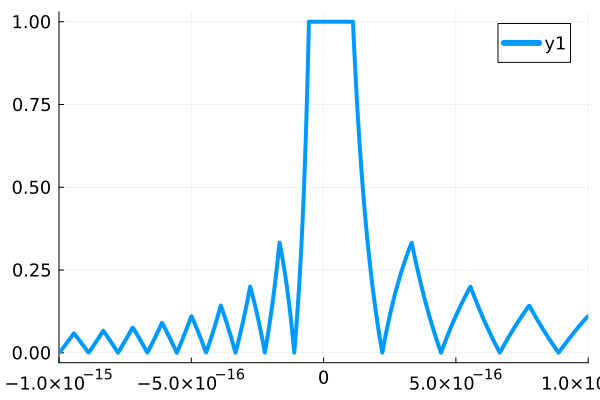

In [97]:
f(x; y=1, z=-1) = (x+y)+z # The best arbitrary numbers are 0, 1, and -1
plot(x -> abs(f(x) - x)/abs(x), xlims=(-1e-15, 1e-15))

# Which operation caused the error?

1. $\texttt{tmp} = \operatorname{fl}(x + 1)$
2. $\operatorname{fl}(\texttt{tmp} - 1)$

Use Julia's [`BigFloat`](https://docs.julialang.org/en/v1/base/numbers/#BigFloats-and-BigInts)

In [98]:
@show typeof(big(.1))
@show big(.1)          # Or BigFloat(.1); parsed as Float64, then promoted
@show BigFloat(".1");  # Parse directly to BigFloat

typeof(big(0.1)) = BigFloat
big(0.1) = 0.1000000000000000055511151231257827021181583404541015625
BigFloat(".1") = 0.1000000000000000000000000000000000000000000000000000000000000000000000000000002


In [99]:
tmp = 1e-15 + 1
tmp_big = big(1e-15) + 1 # Parse as Float64, then promote
abs(tmp - tmp_big) / abs(tmp_big)

1.102230246251563524952071662733800140614440125894379682676737388538642032894338e-16

In [100]:
r = tmp - 1
r_big = big(tmp) - 1
abs(r - r_big) / abs(r_big)

0.0

This last experiment shows that step 2 is exact (there is no rounding). The only approximation occurs when rounding in step 1, and yet I blame step 2 for the error.

# Conditioning

> What sort of functions cause small errors to become big?

Consider a function $f: X \to Y$ and define the **absolute condition number**
$$ \hat\kappa = \lim_{\delta \to 0} \max_{|\delta x| < \delta} \frac{|f(x + \delta x) - f(x)|}{|\delta x|} = \max_{\delta x} \frac{|\delta f|}{|\delta x|}. $$
If $f$ is differentiable, then $\hat\kappa = |f'(x)|$.

Floating point offers relative accuracy, so it's more useful to discuss **relative condition number**,
$$ \kappa = \max_{\delta x} \frac{|\delta f|/|f|}{|\delta x|/|x|}
= \max_{\delta x} \Big[ \frac{|\delta f|/|\delta x|}{|f| / |x|} \Big] $$
or, if $f$ is differentiable,
$$ \kappa = |f'(x)| \frac{|x|}{|f|} . $$